# Win prediction for League of Legends games
In this notebook we implement a logistic regression model to predict the outcome of a League of Legends match based purely on the team composition.

The input is the champions on the red and blue team, as categorical variables (blue one-hot encoded as +1, red as -1), and there is a two node output predicting which team won, blue or red. 

### The notebook is split into the following parts:
1. Import packages and data
2. Format the data
3. Build the NN
4. Train the NN
5. Evaluate the NN on training and test data
6. Make predictions

### 1. Import packages and data

In [1]:
"""
@author: Mark Bugden
August/September 2022

Part of a ML project in predicting win rates for League of Legends games based on team composition.
Current update available on GitHub: https://github.com/Mark-Bugden
"""

# Import necessary packages
import requests
import pandas as pd
from ratelimit import limits, sleep_and_retry
import pickle
import math
import numpy as np
from matplotlib import pyplot as plt
import os
import glob



from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


# This gives us a progress bar for longer computations. 
from tqdm.notebook import tqdm
# To use it, just wrap any iterable with tqdm(iterable).
# Eg: 
# for i in tqdm(range(100)):
#     ....

# Here are the tiers and divisions
tier_list = ['DIAMOND', 'PLATINUM', 'GOLD', 'SILVER', 'BRONZE', 'IRON']
division_list = ['I', 'II', 'III', 'IV']

# Load the champion information
champion_url = 'http://ddragon.leagueoflegends.com/cdn/12.14.1/data/en_US/champion.json'
r = requests.get(champion_url)
json_data = r.json()
champion_data = json_data['data']

champions = list(champion_data.keys())
num_champs = len(champions)

# For some reason Fiddlesticks is listed as FiddleSticks in some of the other data. To avoid problems like this, I will convert all champion names to lowercase
champions = [champ.lower() for champ in champions]


champ_to_num = {k: v for v, k in enumerate(champions)}
num_to_champ = {v: k for v, k in enumerate(champions)}

# We can get champion information by accessing the champion_data dict
# Eg:
# champion_data['Zyra']

In [2]:
# Load the csv file produced in the Get_Match_Data iPython notebook
rankeddf = pd.read_csv('Data collection/ranked_matches.csv') 

# Convert the champion names to lower as well to match up with our champions list.
rankeddf['championName'] = rankeddf['championName'].str.lower()

### 2. Format the data

In [3]:
# Here are three matches
rankeddf.head(30)

,matchId,team,win,championName,summonerName,gameMode
0,EUN1_3205133592,Blue,False,tahmkench,mariogrzyb321,420
1,EUN1_3205133592,Blue,False,elise,xBakuu,420
2,EUN1_3205133592,Blue,False,azir,Vecrone,420
3,EUN1_3205133592,Blue,False,jhin,UNfriendlyEwok,420
4,EUN1_3205133592,Blue,False,yuumi,metrosexual,420
5,EUN1_3205133592,Red,True,garen,DEMACI4,420
6,EUN1_3205133592,Red,True,kayn,zombieldtv,420
7,EUN1_3205133592,Red,True,cassiopeia,whimsical 11 19,420
8,EUN1_3205133592,Red,True,varus,ΞΞ ZielU ΞΞ,420
9,EUN1_3205133592,Red,True,xerath,savo2kk,420


In [4]:
rankeddf.shape

(213330, 6)

In [5]:
# One hot encode a list of champions
def onehotencodechampions(champs):
    ''' One hot encodes a list of champions.
    
    
    '''
    integer_encoded = [champ_to_num[champ] for champ in champs]
    onehot_encoded = [0] * len(champions)
    for value in integer_encoded:
        onehot_encoded[value] = 1
    return onehot_encoded

In [6]:
# We will now put the data into the format we will use for training and testing. This will consist of two lists - the first will be features, and the second will be labels.
# For the features list, each element of the list corresponds to a game, and that element will itself be a list of the champions in that game one-hot-encoded.
# Blue team champions being represented by +1 and red team by -1.

# For the labels list, each element will again be a game, and that element will be a 1 (blue win) or a 0 (red win). 

matches = rankeddf['matchId'].unique().tolist()

features = []
labels = []

for match in tqdm(matches):
    blueteam = rankeddf[(rankeddf['matchId'] == match) & (rankeddf['team'] == 'Blue')]['championName'].tolist()
    redteam = rankeddf[(rankeddf['matchId'] == match) & (rankeddf['team'] == 'Red')]['championName'].tolist()
    
    blueteam = onehotencodechampions(blueteam)
    redteam = [value*-1 for value in onehotencodechampions(redteam)]
    
    features.append([sum(value) for value in zip(blueteam, redteam)])
    
    # We only need to check one champion
    if rankeddf[(rankeddf['matchId'] == match) & (rankeddf['team'] == 'Blue')].iloc[0]['win'] == True:
        labels.append(1)
    else:
        labels.append(0)
    
    
    # Since we are interested in team composition regardless of whether the team is red or blue, we can double the matches by swapping champs and winners
    # That is, champion data swaps +1 and -1, and winner swaps [1,0] and [0,1]. We then randomly select matches later for testing and training.
    
#    features.append([-1*sum(value) for value in zip(blueteam, redteam)])
#    if rankeddf[(rankeddf['matchId'] == match) & (rankeddf['team'] == 'Blue')].iloc[0]['win'] == True:
#        labels.append(0)
#    else:
#        labels.append(1)
    
    

features = np.array(features)        
labels = np.array(labels)

  0%|          | 0/21333 [00:00<?, ?it/s]

In [7]:
features.shape

(21333, 161)

In [8]:
# Split the data into training, validation, and test data


#train_features = features[0 :math.floor(0.7*len(matches))]
#train_labels = labels[0 : math.floor(0.7*len(matches))]

#validation_features = features[math.floor(0.7*len(matches)) : math.floor(0.9*len(matches))]
#validation_labels = labels[math.floor(0.7*len(matches)) : math.floor(0.9*len(matches))]

#test_features = features[math.floor(0.9*len(matches)) : ]
#test_labels = labels[math.floor(0.9*len(matches)) : ]



X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=41)


### 3. Build the model

In [9]:
y_train.shape

(14933,)

In [10]:
logreg = LogisticRegression()


logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [11]:
y_pred_probs = logreg.predict_proba(X_test)[:, 1]
print(y_pred_probs[0])

0.4923257801274944


### 4. Train the network

### 5. Evaluate the network on the training and test data

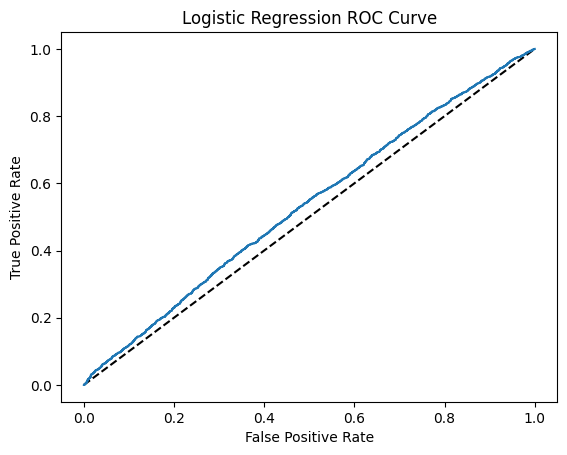

In [12]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

In [13]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_pred_probs))
# Previous roc auc was 0.553688...

0.533240185518259


This actually isn't terrible. If we were just plain guessing, the roc auc score would be 0.5, so anything higher than that represents an improvement upon random chance. 

### 6. Make predictions

We will now predict the winner of a random match of champions. 

In [14]:
# Pick a random selection of champions

pred_champs = np.random.choice(161, 10, replace=False)
pred_blue_champs = pred_champs[0:5]
pred_red_champs = pred_champs[5:]

pred_blue_team = [num_to_champ[champ] for champ in pred_blue_champs]
pred_red_team = [num_to_champ[champ] for champ in pred_red_champs]

print('Blue team is: ', pred_blue_team)
print('Red team is: ', pred_red_team)

Blue team is:  ['seraphine', 'nilah', 'rengar', 'shyvana', 'sett']
Red team is:  ['yorick', 'brand', 'taric', 'xinzhao', 'yuumi']


In [15]:
pred_features = []

pred_blue_team_enc = onehotencodechampions(pred_blue_team)
pred_red_team_enc = [value*-1 for value in onehotencodechampions(pred_red_team)]

pred_features.append([sum(value) for value in zip(pred_blue_team_enc, pred_red_team_enc)])


pred_features = np.array(pred_features)

pred_outcome = logreg.predict(pred_features)
pred_proba = logreg.predict_proba(pred_features)[:, 1]

print(pred_outcome)
print(pred_proba)

[1]
[0.52650328]


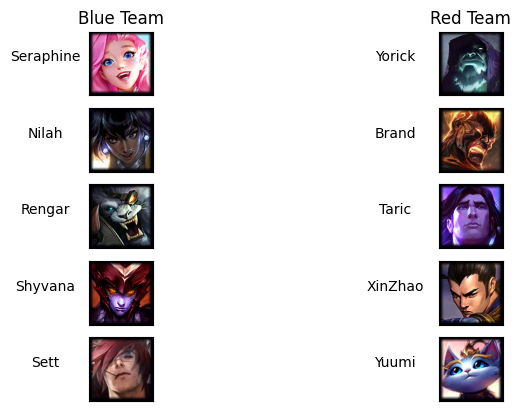

BLUE team is the predicted winner 

Blue win probability:  52.7%
Red win probability:  47.3%


In [16]:
from matplotlib.image import imread

imgarrays = [imread(file) for file in glob.glob('img/Champion icons/*.png')]
champ_list = [champ for champ in champion_data.keys()]



fig, ax = plt.subplots(5,3)

for i in range(5):
    ax[i,0].imshow(imgarrays[champ_to_num[pred_blue_team[i]]])
    ax[i,0].set_ylabel(champ_list[champ_to_num[pred_blue_team[i]]], rotation=0, fontsize='medium', labelpad=28)
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])
    
for i in range(5):
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])
    ax[i,1].axis('off')

for i in range(5):
    ax[i,2].imshow(imgarrays[champ_to_num[pred_red_team[i]]])
    ax[i,2].set_ylabel(champ_list[champ_to_num[pred_red_team[i]]], rotation=0, size='medium', labelpad=28)
    ax[i,2].set_xticks([])
    ax[i,2].set_yticks([])
    
ax[0,0].set_title('Blue Team')
ax[0,2].set_title('Red Team')

plt.show()


# The predicted winner
if (pred_outcome[0]==1):
    print('BLUE team is the predicted winner', '\n')
    print(f'Blue win probability:  {pred_proba[0]:.1%}')
    print(f'Red win probability:  {1-pred_proba[0]:.1%}')
    
elif (pred_outcome[0]==0):
    print('RED team is the predicted winner', '\n')
    print(f'Blue win probability: {pred_proba[0]:.1%}')
    print(f'Red win probability: {1-pred_proba[0]:.1%}')
    
else:
    print('Something went wrong!', '\n')
    print(f'Blue win probability:  {pred_proba[0]:.1%}')
    print(f'Red win probability:  {1-pred_proba[0]:.1%}')


In [17]:


pred_blue_team = ['gnar', 'sylas', 'xayah', 'shaco', 'nami']
pred_red_team = ['nautilus', 'jhin', 'neeko', 'masteryi', 'jax']

pred_blue_team_enc = onehotencodechampions(pred_blue_team)
pred_red_team_enc = [value*-1 for value in onehotencodechampions(pred_red_team)]

In [19]:
print('Blue team is: ', pred_blue_team)
print('Red team is: ', pred_red_team)

Blue team is:  ['gnar', 'sylas', 'xayah', 'shaco', 'nami']
Red team is:  ['nautilus', 'jhin', 'neeko', 'masteryi', 'jax']


In [20]:
pred_features = []

pred_blue_team_enc = onehotencodechampions(pred_blue_team)
pred_red_team_enc = [value*-1 for value in onehotencodechampions(pred_red_team)]

pred_features.append([sum(value) for value in zip(pred_blue_team_enc, pred_red_team_enc)])


pred_features = np.array(pred_features)

pred_outcome = logreg.predict(pred_features)
pred_proba = logreg.predict_proba(pred_features)[:, 1]

print(pred_outcome)
print(pred_proba)

[0]
[0.43176525]
